In [1]:
# Loading the necessary libraries
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load obesity dataset
df = pd.read_csv('datasets/train.csv')

# Split features and target variables
X = df.drop(columns=['obese_category'])
y = df['obese_category']

# Apply label encoding to the target variables
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Apply one-hot encoding to categorical features
X_encoded = pd.get_dummies(X, drop_first=True)


In [3]:
# Split training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


In [4]:
# Initialize XGBoost classifier
xgb_classifier = XGBClassifier(random_state=42)


In [5]:
# Hyperparameter tuning using Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],            
    'max_depth': [3, 5, 7],                         
    'subsample': [0.6, 0.8, 1.0],                   #subsample: The fraction of samples to be used for fitting the individual base learners
    'colsample_bytree': [0.6, 0.8, 1.0],            #colsample_bytree: The fraction of columns to be randomly sampled for each tree
    'gamma': [0, 0.1, 0.2],                         #gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree
}

grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.6, 0.8, 1.0]})

In [6]:
# Best parameters found during grid search
best_params = grid_search.best_params_
print("Best parameters:", best_params)


Best parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.6}


In [7]:
# Train XGBoost classifier with best parameters
xgb_classifier_best = XGBClassifier(**best_params, random_state=42)
xgb_classifier_best.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [8]:
# Predictions on the test set
y_pred = xgb_classifier_best.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

# Calculate balanced accuracy
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy: ", balanced_accuracy)


Accuracy:  0.9005298651252408
Balanced Accuracy:  0.8898202338251284


In [9]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       524
           1       0.87      0.88      0.87       626
           2       0.88      0.87      0.88       543
           3       0.97      0.97      0.97       657
           4       1.00      1.00      1.00       804
           5       0.78      0.77      0.78       484
           6       0.80      0.80      0.80       514

    accuracy                           0.90      4152
   macro avg       0.89      0.89      0.89      4152
weighted avg       0.90      0.90      0.90      4152



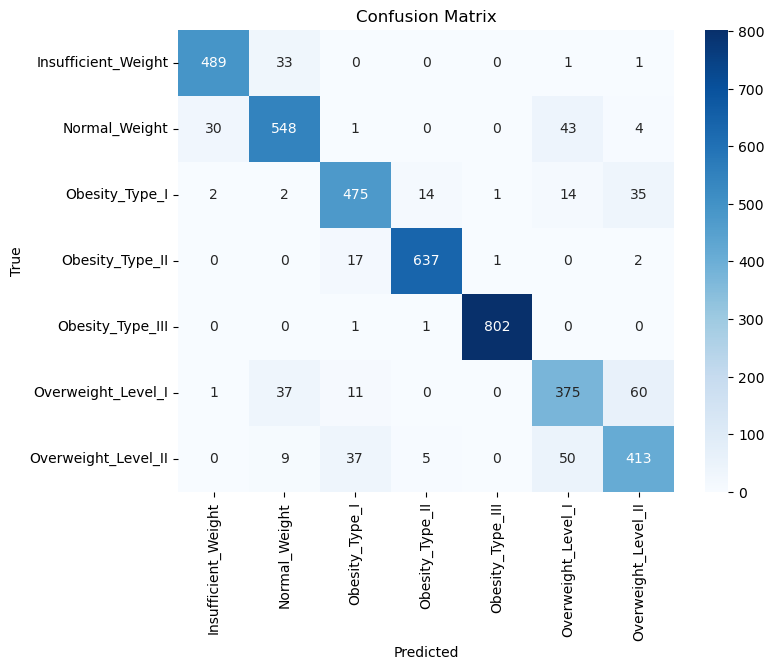

In [10]:
# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


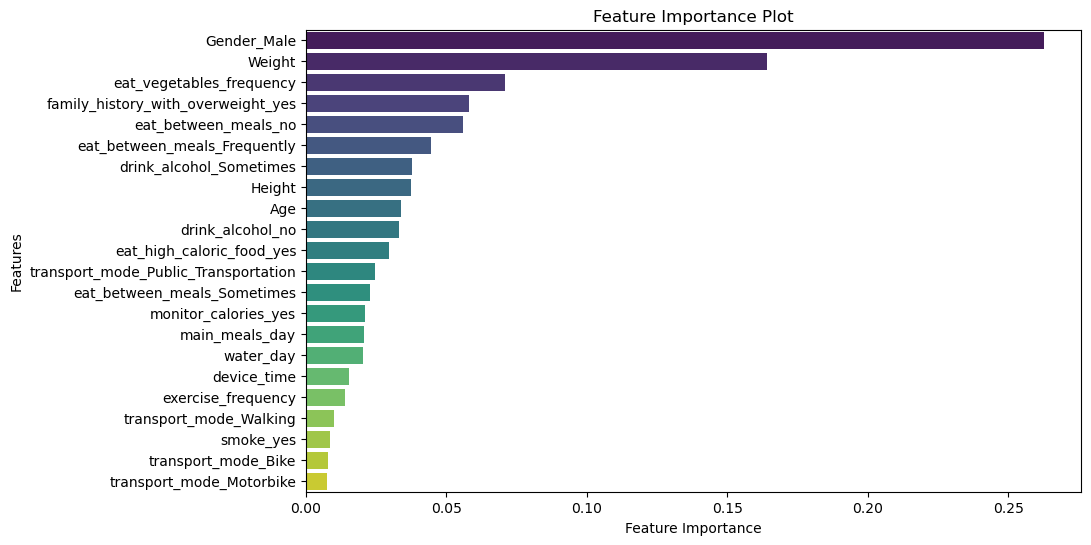

In [11]:
# Feature importance analysis
feature_importance = xgb_classifier_best.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance[sorted_idx], y=X_encoded.columns[sorted_idx], palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.show()
